Trying https://github.com/spdrnl/ecg/blob/master/ECG.ipynb

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Libraries

In [29]:
!unzip /content/drive/"My Drive"/"Arrythmia "/ECGDataDenoised.zip

unzip:  cannot find or open /content/drive/My Drive/Arrythmia /ECGDataDenoised.zip, /content/drive/My Drive/Arrythmia /ECGDataDenoised.zip.zip or /content/drive/My Drive/Arrythmia /ECGDataDenoised.zip.ZIP.


In [4]:
!pip install -q -U tensorflow_addons
!pip3 install py-ecg-detectors
!pip install neurokit2

     |████████████████████████████████| 1.1 MB 5.2 MB/s 
     |████████████████████████████████| 554 kB 7.0 MB/s 
  Created wheel for gatspy: filename=gatspy-0.3-py3-none-any.whl size=43818 sha256=003eaf8057ad8768194082f7d437b5c746235ab0917d372fa75dfb572a876895
  Stored in directory: /root/.cache/pip/wheels/1f/c1/4c/8de278f816259b4f67e2356c0bda260a593375661e400bf31f
Successfully built gatspy
     |████████████████████████████████| 1.1 MB 5.0 MB/s 


In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from scipy import stats
from scipy import signal
from sklearn.model_selection import train_test_split
import sklearn
import itertools
import tensorflow_addons
from tensorflow_addons.optimizers import CyclicalLearningRate
import tensorflow_addons as tfa
import matplotlib as mpl
mpl.style.use('seaborn')
plt.rcParams["figure.figsize"] = (13,4)

import matplotlib.pyplot as plt 
from os import listdir 
import requests
import matplotlib.pyplot as plt
from os import listdir, mkdir, system
from os.path import isfile, isdir, join, exists
import json
import os
from tqdm import tqdm
from matplotlib import collections as matcoll
import pywt

import neurokit2 as nk

from ecgdetectors import Detectors #for pantompkins
detectors = Detectors(500) #specify sampling rate

In [ ]:
labels = pd.read_excel('/content/drive/MyDrive/Arrythmia /Diagnostics.xlsx')
len(labels)

10646

In [ ]:
labels=labels[(labels['Rhythm']=='AFIB') | (labels['Rhythm']=='AF') |(labels['Rhythm']=='SR')]
labels.reset_index(inplace=True,drop=True)
labels['Rhythm'].value_counts()

SR      1826
AFIB    1780
AF       445
Name: Rhythm, dtype: int64

In [ ]:
afib_files = labels[labels['Rhythm']=="AFIB"]['FileName'].tolist()
afib_files.remove('MUSE_20180116_131253_72000')

nsr_files = labels[labels['Rhythm']=="SR"]['FileName'].tolist()
afl_files = labels[labels['Rhythm']=="AF"]['FileName'].tolist()
all_files = afib_files+nsr_files+afl_files

### Preprocessing

In [ ]:
def plot_rr(rrintervals,rr_diff):
  x = rrintervals/500
  y = rr_diff
  lines = []
  for i in range(len(x)):
      pair=[(x[i],0), (x[i], y[i])]
      lines.append(pair)

  linecoll = matcoll.LineCollection(lines)
  fig, ax = plt.subplots()
  ax.add_collection(linecoll)

  plt.scatter(x,y)
  plt.xticks(x)
  plt.xlabel("Time (s)")
  plt.ylim(0,1)
  plt.title("RR Peaks")
  plt.show()

def detect_r_peaks(patient_list,case,showplots=False):
    parent_folder = '/content/ECGDataDenoised/'

    data_with_rr = pd.DataFrame()
    patient_col_id = []
    case_name = []
    mxx=0
    cnt=0
    mnn=90
    for i in tqdm(patient_list):
      # try:
        
        data = parent_folder+i+".csv"
        df = pd.read_csv(data,header=None)
        df.columns=['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']
        cols = df.columns
        df[cols[:-1]] = df[cols[:-1]].apply(pd.to_numeric, errors='coerce')
        lead_name='II'
        count = (df[lead_name] == 0).sum()
        if(count>0):
          print(count)
        if(df[lead_name].isnull().sum(axis = 0)>0):
          print("Null values in ",i,"is :",df[lead_name].isnull().sum(axis = 0))
        # Extract R-peaks locations
        _, rpeaks = nk.ecg_peaks(df["II"][1:], sampling_rate=500)
        rrintervals = rpeaks['ECG_R_Peaks']
        cnt+=len(rrintervals)-1
        
        rr_diff=np.diff(rrintervals)/1000
        rr_diff = np.append(0,rr_diff)

        mxx=max(len(rr_diff),mxx) #to check maximum number of rr intervals for any signal
        mnn=min(len(rr_diff),mnn)

        print(len(rrintervals),len(rr_diff))

        patient_col_id.append(i)
        case_name.append(case)
        data_with_rr=data_with_rr.append(pd.DataFrame(rr_diff).transpose())
        detrended_rri = signal.detrend(rr_diff, axis= -1, type='constant', bp=0, overwrite_data=False)

        if(showplots):
          plot = (nk.events_plot(rpeaks['ECG_R_Peaks'], df["aVL"]))
          plot_rr(rrintervals,rr_diff)
          print("DETRENDED")
          plot_rr(rrintervals,detrended_rri)
          
      # except:
      #   print("\nError in:",i)
    print("\n",case,"    ****Max****:",mxx)
    print("\n",case,"    ****Min****:",mnn,"\n")
    print("Total no. of RR Intervals in",case," class is:",cnt,"\n")
    data_with_rr['filename']=patient_col_id
    data_with_rr['label']=case_name
    return data_with_rr  #returning data containing RR Intervals with label

In [ ]:
def append_r_peaks(patient_list,case,showplots=False):
    rr_ints=[]
    rri_with_patient_id = {}
    # rr_ints=np.array(rr_ints) 
    parent_folder = '/content/ECGDataDenoised/'
    data_with_rr = pd.DataFrame()
    patient_col_id = []
    # case_name = []
    cnt=0
    for i in tqdm(patient_list):
      try:
        data = parent_folder+i+".csv"
        df = pd.read_csv(data,header=None)
        df.columns=['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']
        cols = df.columns
        df[cols[:-1]] = df[cols[:-1]].apply(pd.to_numeric, errors='coerce')
        lead_name='II'
        count = (df[lead_name] == 0).sum()
        if(count>0):
          print(count)
        if(df[lead_name].isnull().sum(axis = 0)>0):
          print("Null values in ",i,"is :",df[lead_name].isnull().sum(axis = 0))
        # Extract R-peaks locations
        _, rpeaks = nk.ecg_peaks(df["II"][1:], sampling_rate=500)
        rrintervals = rpeaks['ECG_R_Peaks']
        cnt+=len(rrintervals)-1
        
        rr_diff=np.diff(rrintervals)/1000
        # rr_diff = np.append(0,rr_diff) #adding this 0 for equal size of RRi , hence to plot
        rr_ints = np.append(rr_ints,rr_diff)
        patient_col_id.append(i)
        # case_name.append(case)
        data_with_rr=data_with_rr.append(pd.DataFrame(rr_diff).transpose())
        detrended_rri = signal.detrend(rr_diff, axis= -1, type='constant', bp=0, overwrite_data=False)
        rri_with_patient_id[i]=detrended_rri
      except:
        print("\nError in:",i)

    print("Total no. of RR Intervals in",case," class is:",len(rr_ints),"\n")
    return rri_with_patient_id  #returning data containing RR Intervals with label

In [ ]:
'''
  old one appending all arrays
'''
# def append_r_peaks(patient_list,case,showplots=False):
#     rr_ints=[]
#     rr_ints=np.array(rr_ints)
#     parent_folder = '/content/ECGDataDenoised/'
#     data_with_rr = pd.DataFrame()
#     data_with_rr = pd.DataFrame()
#     patient_col_id = []
#     case_name = []
#     cnt=0
#     for i in tqdm(patient_list):
#       try:
#         data = parent_folder+i+".csv"
#         df = pd.read_csv(data,header=None)
#         df.columns=['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']
#         cols = df.columns
#         df[cols[:-1]] = df[cols[:-1]].apply(pd.to_numeric, errors='coerce')
#         lead_name='II'
#         count = (df[lead_name] == 0).sum()
#         if(count>0):
#           print(count)
#         if(df[lead_name].isnull().sum(axis = 0)>0):
#           print("Null values in ",i,"is :",df[lead_name].isnull().sum(axis = 0))
#         # Extract R-peaks locations
#         _, rpeaks = nk.ecg_peaks(df["II"][1:], sampling_rate=500)
#         rrintervals = rpeaks['ECG_R_Peaks']
#         cnt+=len(rrintervals)-1
        
#         rr_diff=np.diff(rrintervals)/1000
#         # rr_diff = np.append(0,rr_diff) #adding this 0 for equal size of RRi 
#         rr_ints = np.append(rr_ints,rr_diff)
#         patient_col_id.append(i)
#         case_name.append(case)
#         data_with_rr=data_with_rr.append(pd.DataFrame(rr_diff).transpose())
#         detrended_rri = signal.detrend(rr_diff, axis= -1, type='constant', bp=0, overwrite_data=False)
#       except:
#         print("\nError in:",i)

#     print("Total no. of RR Intervals in",case," class is:",len(rr_ints),"\n")
#     return rr_ints  #returning data containing RR Intervals with label

'\n  old one appending all arrays\n'

In [ ]:
# nsr_rr=detect_r_peaks_pan_tompkins_detector(nsr_files,"nsr","pan_tompkins",False)
# afib_rr=detect_r_peaks_pan_tompkins_detector(afib_files,"afib","pan_tompkins",False)
# afl_rr=detect_r_peaks_pan_tompkins_detector(afl_files,"afl","pan_tompkins",False)

In [ ]:
# detect_r_peaks(nsr_files[:15],"nsr",False) #just to check

In [ ]:
# len(append_r_peaks(nsr_files[:15],"nsr")) #just to check

In [ ]:
nsr_rri=append_r_peaks(nsr_files,"nsr")
afib_rri=append_r_peaks(afib_files,"afib")
afl_rri=append_r_peaks(afl_files,"afl")

100%|██████████| 1826/1826 [00:41<00:00, 43.88it/s]


Total no. of RR Intervals in nsr  class is: 20520 



 91%|█████████ | 1620/1779 [00:39<00:04, 36.71it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1779/1779 [00:43<00:00, 41.03it/s]


Total no. of RR Intervals in afib  class is: 25124 



100%|██████████| 445/445 [00:12<00:00, 34.74it/s]

Total no. of RR Intervals in afl  class is: 7491 



In [ ]:
nsr_extraction_rr = pd.DataFrame.from_dict(nsr_rri,orient='index')
afl_extraction_rr = pd.DataFrame.from_dict(afl_rri,orient='index')
afib_extraction_rr = pd.DataFrame.from_dict(afib_rri,orient='index')

In [ ]:
all_subjects=all_files
subject_label = {}
for i in afib_files:
    subject_label[i] = 'afib'
for i in nsr_files:
    subject_label[i] = 'nsr'
for i in afl_files:
    subject_label[i] = 'afl'

In [ ]:
# def extractor()

In [ ]:
# scikit-learn k-fold cross-validation
from numpy import array
from sklearn.model_selection import KFold
data=all_subjects

# prepare cross validation
kfold = KFold(10,shuffle=True,random_state=42)

# enumerate splits
for train, test in kfold.split(data):  
  cnt_train={}
  nsr_det_rri = []
  nsr_det_rri = np.array(nsr_det_rri)
  afib_det_rri = []
  afib_det_rri = np.array(afib_det_rri)
  afl_det_rri = []
  afl_det_rri = np.array(afl_det_rri)
  afl_list = []
  for i in train:
    label=subject_label[all_subjects[i]]
    if label in cnt_train:
      cnt_train[label]+=1
    else:
      cnt_train[label]=1
    name=all_subjects[i]
    if(label=='nsr'):
      nsr_det_rri=np.append(nsr_det_rri,nsr_rri[name])
    elif(label=='afl'):
      afl_list.append(name)
      afl_det_rri=np.append(afl_det_rri,afl_rri[name])
    else:
      afib_det_rri=np.append(afib_det_rri,afib_rri[name])
    ## 
  print("Train:",cnt_train)
  print(len(afib_det_rri),len(nsr_det_rri),len(afl_det_rri))

  p1 = np.random.permutation(afl_list)
  p2 = np.random.permutation(afl_list)
  # print(len(p1)," , ",len(p2))
  for k in p1:
    afl_det_rri=np.append(afl_det_rri,afl_rri[k])
  for k in p2:
    afl_det_rri=np.append(afl_det_rri,afl_rri[k])
  print("After patient Scrambling:",len(afl_det_rri))


#### Similar to train

  nsr_det_rri_test = []
  nsr_det_rri_test = np.array(nsr_det_rri_test)
  afib_det_rri_test = []
  afib_det_rri_test = np.array(afib_det_rri_test)
  afl_det_rri_test = []
  afl_det_rri_test = np.array(afl_det_rri_test)

  cnt_test={}
  afl_list = []
  for i in test:
    label=subject_label[all_subjects[i]]
    if label in cnt_test:
      cnt_test[label]+=1
    else:
      cnt_test[label]=1
    name=all_subjects[i]
    if(label=='nsr'):
      nsr_det_rri_test=np.append(nsr_det_rri_test,nsr_rri[name])
    elif(label=='afl'):
      afl_list.append(name)
      afl_det_rri_test=np.append(afl_det_rri_test,afl_rri[name])
    else:
      afib_det_rri_test=np.append(afib_det_rri_test,afib_rri[name])
     ## 
  print("Test:",cnt_test)
  print(len(afib_det_rri_test),len(nsr_det_rri_test),len(afl_det_rri_test))
  
  p1 = np.random.permutation(afl_list)
  p2 = np.random.permutation(afl_list)
  for k in p1:
    afl_det_rri_test=np.append(afl_det_rri_test,afl_rri[k])
  for k in p2:
    afl_det_rri_test=np.append(afl_det_rri_test,afl_rri[k])
  print("After patient Scrambling:",len(afl_det_rri_test))

  break
  #1 fold done call rest part in function to complete your k fold cv

Train: {'afib': 1592, 'nsr': 1652, 'afl': 401}
22573 18567 6786
After patient Scrambling: 20358
Test: {'afib': 187, 'nsr': 174, 'afl': 44}
2551 1953 705
After patient Scrambling: 2115


In [ ]:
def round_robin(RR_interval):

  RR_interval=RR_interval.tolist()
  wind_size = 100
  data_vect = []
  modified_data_vector = []
  ex_index = []

  #CREATE DATA VECTOR
  for i in tqdm(range(len(RR_interval))):

    if i < len(RR_interval):

      if len(RR_interval) >= i+wind_size:
        rr_interval = RR_interval[i:i+wind_size]
        data_vect.append(rr_interval)
      else:
        RR_interval.extend(RR_interval[0:100])
        rr_interval = RR_interval[i:i+wind_size]
        data_vect.append(rr_interval)

  # #REMOVE EQUIDISTANT VECTORS
  # for v in tqdm(range(len(data_vect))):
    
  #   if v in ex_index:
  #     continue
  #   else:
  #     next_data = data_vect[v+1: len(data_vect)-1]
  #     c = 0
  #     for vi in range(len(next_data)):
        
  #       if len(data_vect[v])==len(next_data[vi]):

  #         np_sub_array = np.absolute(np.array(data_vect[v]) - np.array(next_data[vi]))
  #         result = np.all(np_sub_array == np_sub_array[0])
  #         if result == True:
  #           ex_index.append(v+1+vi)
  #           c+=1
  #     if c == 0:
  #       modified_data_vector.append(data_vect[v])

  # return modified_data_vector
  return np.array(data_vect)

In [ ]:
afib_vectors = round_robin(afib_det_rri)
afl_vectors = round_robin(afl_det_rri)
nsr_vectors = round_robin(nsr_det_rri)
len__puncture = min(len(afib_vectors),min(len(nsr_vectors),len(afl_vectors)))

100%|██████████| 18567/18567 [00:00<00:00, 381720.89it/s]


In [ ]:
afib_vectors = afib_vectors[:len__puncture]
afl_vectors = afl_vectors[:len__puncture]
nsr_vectors = nsr_vectors[:len__puncture]

In [ ]:
afib_rr = pd.DataFrame(afib_vectors)
afib_rr['label']='afib'
nsr_rr = pd.DataFrame(nsr_vectors)
nsr_rr['label']='nsr'
afl_rr = pd.DataFrame(afl_vectors)
afl_rr['label']='afl'

In [ ]:
arhy_labels = {'nsr': 0, 'afib': 1, 'afl':2}
arhy_reverse_labels = {v:k for k,v in arhy_labels.items()}

full_data_with_rr=pd.concat([afib_rr,nsr_rr,afl_rr])

# full_data_with_rr['label']=full_data_with_rr['label'].astype("string")

arhy_labels = full_data_with_rr.iloc[:,-1].replace(arhy_reverse_labels)

In [ ]:
full_data_with_rr

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,label
0,-0.021278,0.007722,-0.021278,0.022722,0.010722,0.034722,0.015722,0.005722,-0.018278,0.025722,...,0.027308,0.125308,-0.086692,0.101308,-0.069692,0.073308,-0.008692,0.012308,-0.068692,afib
1,0.007722,-0.021278,0.022722,0.010722,0.034722,0.015722,0.005722,-0.018278,0.025722,0.007722,...,0.125308,-0.086692,0.101308,-0.069692,0.073308,-0.008692,0.012308,-0.068692,-0.099692,afib
2,-0.021278,0.022722,0.010722,0.034722,0.015722,0.005722,-0.018278,0.025722,0.007722,0.016722,...,-0.086692,0.101308,-0.069692,0.073308,-0.008692,0.012308,-0.068692,-0.099692,-0.036722,afib
3,0.022722,0.010722,0.034722,0.015722,0.005722,-0.018278,0.025722,0.007722,0.016722,-0.067278,...,0.101308,-0.069692,0.073308,-0.008692,0.012308,-0.068692,-0.099692,-0.036722,-0.032722,afib
4,0.010722,0.034722,0.015722,0.005722,-0.018278,0.025722,0.007722,0.016722,-0.067278,0.012722,...,-0.069692,0.073308,-0.008692,0.012308,-0.068692,-0.099692,-0.036722,-0.032722,0.065278,afib
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18562,0.013000,0.025000,-0.013000,0.003000,-0.021000,0.005000,0.043000,-0.005000,0.064000,-0.012000,...,-0.050412,-0.049412,0.372588,-0.050412,-0.049412,-0.049412,-0.049412,0.161588,-0.049412,afl
18563,0.025000,-0.013000,0.003000,-0.021000,0.005000,0.043000,-0.005000,0.064000,-0.012000,-0.008000,...,-0.049412,0.372588,-0.050412,-0.049412,-0.049412,-0.049412,0.161588,-0.049412,-0.050412,afl
18564,-0.013000,0.003000,-0.021000,0.005000,0.043000,-0.005000,0.064000,-0.012000,-0.008000,-0.015000,...,0.372588,-0.050412,-0.049412,-0.049412,-0.049412,0.161588,-0.049412,-0.050412,-0.049412,afl
18565,0.003000,-0.021000,0.005000,0.043000,-0.005000,0.064000,-0.012000,-0.008000,-0.015000,-0.007474,...,-0.050412,-0.049412,-0.049412,-0.049412,0.161588,-0.049412,-0.050412,-0.049412,-0.049412,afl


### Labelling encoding {'nsr': 0, 'afib': 1, 'afl':2}


In [ ]:
dict = {'nsr': 0, 'afib': 1, 'afl':2}

full_data_with_rr.replace({'label': dict},inplace=True)

In [ ]:
# full_data_with_rr.to_csv("/content/drive/MyDrive/train_data_rr_100.csv",index=False)
# full_data_with_rr.to_csv("/content/train_data_rr_100.csv",index=False)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/train_data_rr_100.csv")
df.label.value_counts()

1    18567
0    18567
2    18567
Name: label, dtype: int64

In [ ]:
plt.hist(arhy_labels)
plt.title("Distribution of the labels")

In [ ]:
arhy_labels.value_counts()
# 'nsr': 0, 'afib': 1, 'afl':2

In [ ]:
train=df

In [ ]:
train.to_csv("/content/drive/MyDrive/train_rr_100.csv",index=False)
train.to_csv("/content/train_rr_100.csv",index=False)


### Start from here. Read Train file which is already saved

In [9]:
# train=pd.read_csv("/content/drive/MyDrive/train_with_rr_20.csv")
train=pd.read_csv("/content/drive/MyDrive/train_data_rr_100.csv")
train = train.sample(frac=1).reset_index(drop=True)
train = train.sample(frac=1).reset_index(drop=True)



In [10]:
train

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,label
0,0.007600,-0.013400,0.010600,0.010600,-0.014400,0.003600,0.012600,-0.004400,0.003917,0.001917,...,0.002462,0.000462,0.000462,-0.004538,-0.006538,-0.000538,0.003462,0.007462,0.003462,0
1,0.124636,0.051636,0.037636,-0.078364,-0.093364,0.070812,-0.064187,0.119812,0.041812,-0.056188,...,-0.014476,0.065200,-0.064800,-0.060800,-0.102800,-0.047800,0.201200,-0.048800,0.028200,1
2,0.010182,0.005182,-0.007818,-0.000818,-0.002818,-0.012818,-0.011818,-0.015818,-0.003231,-0.009231,...,0.000769,-0.013231,-0.026231,-0.011231,-0.003231,0.009769,-0.004231,-0.004231,0.004769,0
3,-0.033375,0.052625,-0.025375,0.046625,-0.053375,0.059625,-0.058375,0.053625,-0.065375,-0.031375,...,-0.059000,0.044000,-0.013000,-0.014000,0.015000,0.019000,0.005000,0.048000,-0.020818,1
4,-0.001545,-0.001545,-0.001545,-0.005545,-0.002545,0.007455,0.005455,0.006455,0.002455,-0.003545,...,-0.008333,0.003667,0.005667,-0.017167,-0.049167,0.011833,-0.008167,-0.045167,0.010833,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55696,0.004167,0.008273,0.003273,0.010273,0.016273,0.009273,0.001273,0.005273,0.003273,-0.017727,...,0.002400,-0.010077,-0.008077,0.001923,0.005923,0.012923,0.007923,-0.003077,-0.012077,0
55697,-0.055083,-0.050083,0.107917,-0.066083,-0.081083,0.176917,0.086917,-0.028083,-0.047083,-0.024583,...,-0.044500,0.046500,-0.034500,0.071500,-0.008684,-0.011684,-0.028684,-0.032684,-0.025684,2
55698,-0.004444,-0.000444,0.001556,-0.002444,0.000556,0.001556,-0.000444,-0.000444,0.004556,0.003000,...,-0.063500,0.002900,0.003900,0.004900,0.000900,-0.006100,-0.006100,0.003900,-0.004100,0
55699,-0.040933,-0.009933,-0.041933,-0.064933,0.057067,-0.018933,0.049136,0.029136,0.027136,0.013136,...,-0.029765,0.031235,0.024235,-0.040765,0.115235,-0.008765,-0.091765,0.051235,-0.011765,1


In [11]:
full_data_with_rr=train
full_data_with_rr['label'].value_counts()

0    18567
1    18567
2    18567
Name: label, dtype: int64

In [12]:
# full_data_with_rr.drop(columns=['filename'],inplace=True)

In [13]:
# Copied from https://github.com/avanwyk/tensorflow-projects/blob/master/lr-finder/lr_finder.py
# Apache License 2.0

from tensorflow.keras.callbacks import Callback

class LRFinder(Callback):
    """`Callback` that exponentially adjusts the learning rate after each training batch between `start_lr` and
    `end_lr` for a maximum number of batches: `max_step`. The loss and learning rate are recorded at each step allowing
    visually finding a good learning rate as per https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html via
    the `plot` method.
    """

    def __init__(self, start_lr: float = 1e-2, end_lr: float = 10, max_steps: int = 100, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self):
        fig, ax = plt.subplots(1, 1)
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate (log scale)')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs, self.losses)

In [14]:
def pretty_plot(history, field, fn):
  def plot(data, val_data, best_index, best_value, title):
    plt.plot(range(1, len(data)+1), data, label='train')
    plt.plot(range(1, len(data)+1), val_data, label='validation')
    if not best_index is None:
      plt.axvline(x=best_index+1, linestyle=':', c="#777777")
    if not best_value is None:
      plt.axhline(y=best_value, linestyle=':', c="#777777")
    plt.xlabel('Epoch')
    plt.ylabel(field)
    plt.xticks(range(0, len(data), 20))
    plt.title(title)
    plt.legend()
    plt.show()

  data = history.history[field]
  val_data = history.history['val_' + field]
  tail = int(0.15 * len(data))

  best_index = fn(val_data)
  best_value = val_data[best_index]

  plot(data, val_data, best_index, best_value, "{} over epochs (best {:06.4f})".format(field, best_value))
  plot(data[-tail:], val_data[-tail:], None, best_value, "{} over last {} epochs".format(field, tail))

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [16]:
def get_base_model(categories=3):
  return keras.Sequential([
    keras.layers.Dense(10, activation='relu', input_shape=[100], kernel_regularizer=regularizers.l2(0.001)),
    # keras.layers.Dense(25, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    keras.layers.Dense(3, activation='relu'),
    (keras.layers.Dense(1, activation='sigmoid') if categories == 3 else keras.layers.Dense(5, activation='softmax'))                   
  ])

In [17]:
X_arhy_train, X_arhy_val, y_arhy_train, y_arhy_val = train_test_split(full_data_with_rr.iloc[:,:-1].values, full_data_with_rr.iloc[:,-1].values, test_size=0.2, random_state=42)
X_arhy_val, X_arhy_test, y_arhy_val, y_arhy_test  = train_test_split(X_arhy_val, y_arhy_val, test_size=0.5, random_state=42)

print("All features size {}".format(full_data_with_rr.iloc[:,:-1].shape))
print("Train features size {}".format(X_arhy_train.shape))
print("Validation features size {}".format(X_arhy_val.shape))
print("Test features size {}".format(X_arhy_test.shape))

All features size (55701, 100)
Train features size (44560, 100)
Validation features size (5570, 100)
Test features size (5571, 100)


In [18]:
X_arhy_train

array([[-0.001     ,  0.002     ,  0.003     , ..., -0.0116    ,
         0.0154    ,  0.0204    ],
       [-0.02122222, -0.04022222,  0.06177778, ..., -0.09005556,
         0.04694444,  0.01894444],
       [ 0.00733333,  0.17433333,  0.01033333, ...,  0.0224    ,
         0.2184    , -0.0846    ],
       ...,
       [-0.00107692, -0.01061538, -0.00661538, ...,  0.00625   ,
         0.01225   ,  0.00725   ],
       [ 0.04091667,  0.04191667,  0.04291667, ...,  0.00164706,
        -0.00035294, -0.00035294],
       [-0.00809091, -0.02709091,  0.00190909, ...,  0.03618182,
         0.09918182,  0.02318182]])

### ResNet Model

In [19]:
def get_resnet_model(categories=3): #original
  def residual_block(X, kernels, stride):
    out = keras.layers.Conv1D(64,kernels, stride, padding='same')(X)
    # out = keras.layers.ReLU()(out)
    # out = keras.layers.Conv1D(kernels, stride, padding='same')(out)
    out = keras.layers.add([X, out])
    out = keras.layers.ReLU()(out)
    out = keras.layers.MaxPool1D(1, 3)(out)
    return out

  kernels = 32
  stride = 1

  inputs = keras.layers.Input([100,1])
  X = keras.layers.Conv1D(64,kernels, stride)(inputs)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = keras.layers.Flatten()(X)
  X = keras.layers.Dense(32, activation='relu')(X)
  X = keras.layers.Dense(32, activation='relu')(X)
  output = (keras.layers.Dense(1, activation='sigmoid')(X) if categories == 3 else keras.layers.Dense(5, activation='softmax')(X))

  model = keras.Model(inputs=inputs, outputs=output)
  return model

### Paper ResNet model

In [ ]:
from tensorflow.keras.layers import BatchNormalization

Fig. 5. Network diagram. The data flow starts from the input vector with 100 detrended RR intervals. Block 1 consists of three 1D convolution layers with 64 filters each and the kernel size is 8, 5, and 3 respectively. Between each convolution layers there are batch normalization and activation layers. The residual path is provided by a 1D convolution (64 filters and a kernel size of 1) with batch normalization. Blocks 2 and 3 have the same setup, the number of filters in the convolution layers is 128. The output is established with global average pooling and a dense layer with sigmoid activation.


In [ ]:
def identity_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv1D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [ ]:
def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [ ]:
def ResNet34(shape = (32, 32, 3), classes = 10):
    # Step 1 (Setup Input Layer)
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    # Step 2 (Initial Conv layer along with maxPool)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    # Define size of sub-blocks and initial filter size
    block_layers = [3, 4, 6, 3]
    filter_size = 64
    # Step 3 Add the Resnet Blocks
    for i in range(4):
        if i == 0:
            # For sub-block 1 Residual/Convolutional block not needed
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            # One Residual/Convolutional Block followed by Identity blocks
            # The filter size will go on increasing by a factor of 2
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    # Step 4 End Dense Network
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet34")
    return model

In [ ]:
def get_resnet_model(categories=3):
  def residual_block(X, kernels=1, stride=1):
    out = keras.layers.Conv1D(64,kernels, stride, padding='same')(X)
    X = BatchNormalization()(X)
    out = keras.layers.ReLU()(out)
    
    out = keras.layers.add([X, out])
    out = keras.layers.ReLU()(out)
    out = keras.layers.MaxPool1D(1, 3)(out)
    return out

  kernels = 32
  stride = 1

  inputs = keras.layers.Input([100,1])
  X = keras.layers.Conv1D(64,8, stride)(inputs)
  X = BatchNormalization()(X)
  X = keras.layers.ReLU()(X)

  X = keras.layers.Conv1D(64,5, stride)
  X = BatchNormalization()(X)
  X = keras.layers.ReLU()(X)
  X = keras.layers.Conv1D(64,3, stride)
  X = BatchNormalization()(X)
  X = keras.layers.ReLU()(X)

  
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = keras.layers.Flatten()(X)
  X = keras.layers.Dense(32, activation='relu')(X)
  X = keras.layers.Dense(32, activation='relu')(X)
  output = (keras.layers.Dense(1, activation='sigmoid')(X) if categories == 3 else keras.layers.Dense(5, activation='softmax')(X))

  model = keras.Model(inputs=inputs, outputs=output)
  return model

In [ ]:
X_arhyl_train = np.expand_dims(X_arhy_train, -1)
y_arhyl_train = np.expand_dims(y_arhy_train, -1)

X_arhyl_val = np.expand_dims(X_arhy_val, -1)
y_arhyl_val = np.expand_dims(y_arhy_val, -1)

X_arhyl_test = np.expand_dims(X_arhy_test, -1)
y_arhyl_test = np.expand_dims(y_arhy_test, -1)

In [ ]:
X_arhyl_train.shape

(44560, 100, 1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


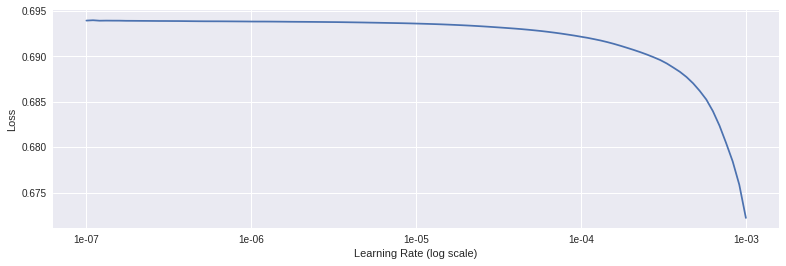

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)
model = get_resnet_model() 
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

lr_finder = LRFinder(start_lr=1e-7, end_lr= 1e-03, max_steps=100, smoothing=0.6)
_ = model.fit(X_arhyl_train, y_arhyl_train, batch_size=256, epochs=5, callbacks=[lr_finder], verbose=False)
lr_finder.plot()

In [ ]:
pip list | grep tensorflow

tensorflow                    2.8.0
tensorflow-addons             0.16.1
tensorflow-datasets           4.0.1
tensorflow-estimator          2.8.0
tensorflow-gcs-config         2.8.0
tensorflow-hub                0.12.0
tensorflow-io-gcs-filesystem  0.24.0
tensorflow-metadata           1.7.0
tensorflow-probability        0.16.0


In [ ]:
# Set cyclical learning rate
N = X_arhyl_train.shape[0]
batch_size = 128
iterations = N/batch_size
step_size= 2 * iterations

lr_schedule = CyclicalLearningRate(1e-6, 1e-3, step_size=step_size, scale_fn=lambda x: tf.pow(0.95,x))
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

save_best_weights = ModelCheckpoint(filepath="weights.hdf5", verbose=0, save_best_only=True)

resnet_model = get_resnet_model() 
resnet_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = resnet_model.fit(X_arhyl_train, y_arhyl_train, validation_data=(X_arhyl_val, y_arhyl_val), 
                           shuffle=True, batch_size=batch_size, epochs=20, callbacks=[save_best_weights])

Epoch 1/20
349/349 [==============================] - 14s 36ms/step - loss: -58.9506 - accuracy: 0.3303 - val_loss: -3574.1577 - val_accuracy: 0.3354
Epoch 2/20
349/349 [==============================] - 12s 34ms/step - loss: -89433516802048.0000 - accuracy: 0.3331 - val_loss: -1887354524532736.0000 - val_accuracy: 0.3354
Epoch 3/20
349/349 [==============================] - 12s 34ms/step - loss: -2083359167795429376.0000 - accuracy: 0.3331 - val_loss: -10383241355437539328.0000 - val_accuracy: 0.3354
Epoch 4/20
349/349 [==============================] - 12s 35ms/step - loss: -29219299406798389248.0000 - accuracy: 0.3331 - val_loss: -43202120829737369600.0000 - val_accuracy: 0.3354
Epoch 5/20
349/349 [==============================] - 12s 33ms/step - loss: nan - accuracy: 0.3326 - val_loss: nan - val_accuracy: 0.3289
Epoch 6/20
349/349 [==============================] - 13s 37ms/step - loss: nan - accuracy: 0.3339 - val_loss: nan - val_accuracy: 0.3289
Epoch 7/20
349/349 [=============

KeyboardInterrupt: ignored

In [ ]:
pretty_plot(history, 'loss', lambda x: np.argmin(x))

NameError: ignored

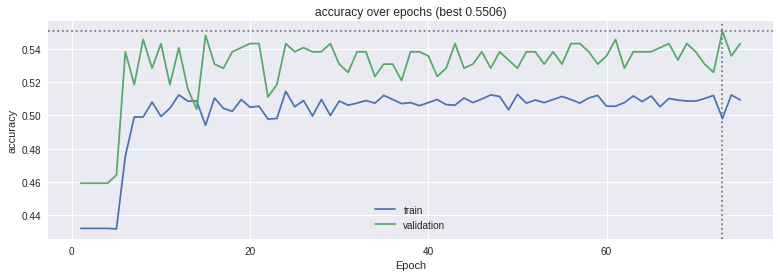

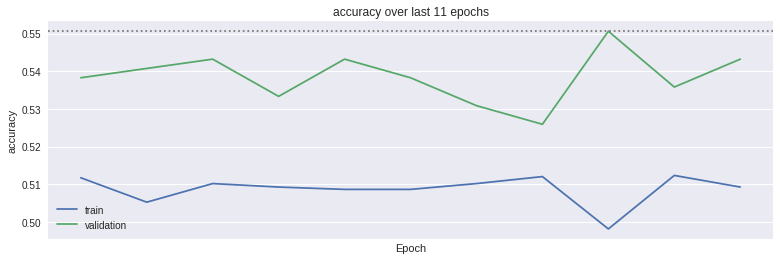

In [ ]:
pretty_plot(history, 'accuracy', lambda x: np.argmax(x))

In [ ]:
resnet_model.load_weights('weights.hdf5')
resnet_model.evaluate(X_arhyl_test, y_arhyl_test)

13/13 [==============================] - 0s 17ms/step - loss: 0.6401 - accuracy: 0.5222


[0.6400601267814636, 0.5221675038337708]

Confusion matrix, without normalization
[[ 43 136   0]
 [ 25 169   0]
 [  1  32   0]]


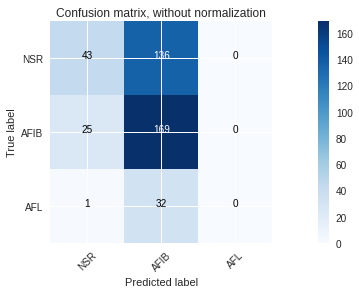

In [ ]:
y_pred = (resnet_model.predict(X_arhyl_test) > 0.5).astype("int32")
# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(y_arhy_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['NSR', 'AFIB','AFL'],
                      title='Confusion matrix, without normalization')

## ResNet MIT-BIH replication

In [20]:
X_arhy_train, X_arhy_val, y_arhy_train, y_arhy_val = train_test_split(full_data_with_rr.iloc[:,:-1].values, full_data_with_rr.iloc[:,-1].values,test_size=0.1, random_state=42)

X_arhy_test, X_arhy_val, y_arhy_test, y_arhy_val = train_test_split(X_arhy_val,y_arhy_val,test_size=0.5, random_state=42)

# The 1D convolutions expect an extra dimension in the input data 
X_arhyl_train = np.expand_dims(X_arhy_train, -1)
y_arhyl_train = np.expand_dims(y_arhy_train, -1)
X_arhyl_val = np.expand_dims(X_arhy_val, -1)
y_arhyl_val = np.expand_dims(y_arhy_val, -1)
X_arhyl_test = np.expand_dims(X_arhy_test, -1)
y_arhyl_test = np.expand_dims(y_arhy_test, -1)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


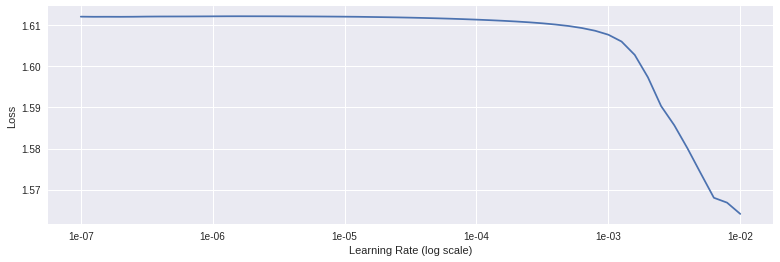

In [23]:
N = X_arhyl_train.shape[0]
batch_size = 128
iterations = N/batch_size
step_size= 2 * iterations

optimizer = keras.optimizers.Adam(lr=0.001)
model = get_resnet_model(5) 
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lr_finder = LRFinder(start_lr=1e-7, end_lr= 1e-02, max_steps=50, smoothing=0.6)
_ = model.fit(X_arhyl_train, y_arhyl_train, batch_size=256, epochs=5, callbacks=[lr_finder], verbose=False)
lr_finder.plot()

In [24]:
lr_schedule = CyclicalLearningRate(1e-5, 1e-2, step_size=step_size, scale_fn=lambda x: tf.pow(0.95,x))
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
m_resnet_model = get_resnet_model(7)

save_best_weights = ModelCheckpoint(filepath="weights.hdf5", verbose=0, save_best_only=True)

m_resnet_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = m_resnet_model.fit(X_arhyl_train, y_arhyl_train, validation_data=(X_arhyl_val, y_arhyl_val), 
                             shuffle=True, batch_size=128, epochs=8, callbacks=[save_best_weights])

Epoch 1/8
392/392 [==============================] - 7s 14ms/step - loss: 0.5750 - accuracy: 0.7573 - val_loss: 0.3058 - val_accuracy: 0.8859
Epoch 2/8
392/392 [==============================] - 4s 10ms/step - loss: 0.2634 - accuracy: 0.8988 - val_loss: 0.2390 - val_accuracy: 0.8977
Epoch 3/8
392/392 [==============================] - 4s 9ms/step - loss: 0.1306 - accuracy: 0.9516 - val_loss: 0.0691 - val_accuracy: 0.9720
Epoch 4/8
392/392 [==============================] - 3s 8ms/step - loss: 0.0306 - accuracy: 0.9891 - val_loss: 0.0318 - val_accuracy: 0.9899
Epoch 5/8
392/392 [==============================] - 3s 8ms/step - loss: 0.0238 - accuracy: 0.9910 - val_loss: 0.0706 - val_accuracy: 0.9734
Epoch 6/8
392/392 [==============================] - 3s 8ms/step - loss: 0.0759 - accuracy: 0.9735 - val_loss: 0.0942 - val_accuracy: 0.9623
Epoch 7/8
392/392 [==============================] - 3s 8ms/step - loss: 0.0524 - accuracy: 0.9826 - val_loss: 0.0419 - val_accuracy: 0.9860
Epoch 8/8
3

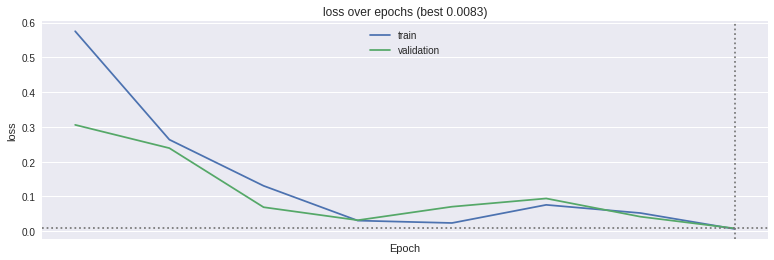

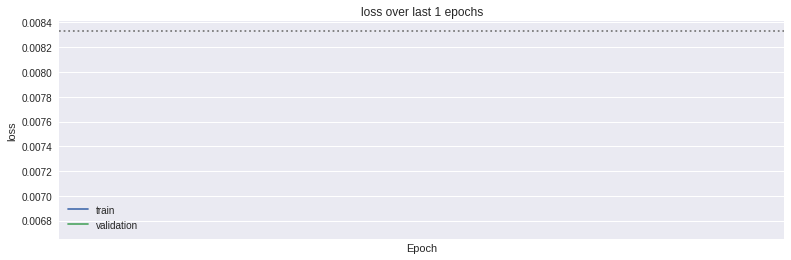

In [25]:
pretty_plot(history, 'loss', lambda x: np.argmin(x))

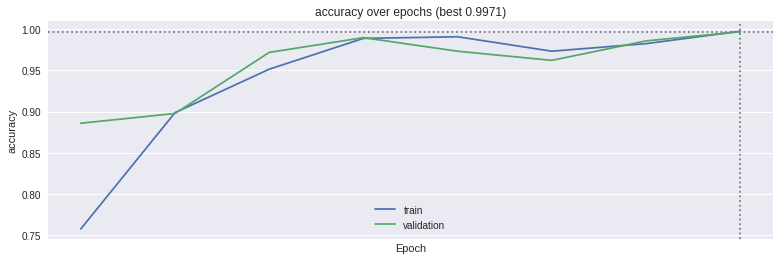

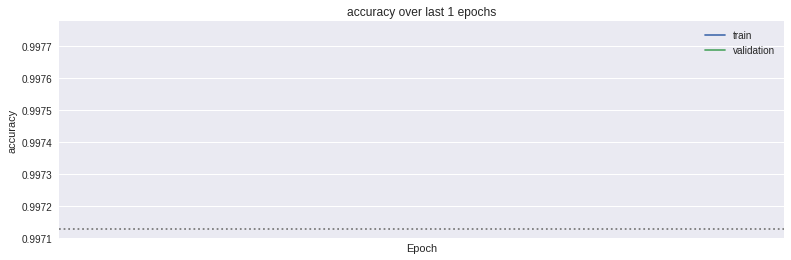

In [26]:
pretty_plot(history, 'accuracy', lambda x: np.argmax(x))

In [27]:
m_resnet_model.load_weights('weights.hdf5')
X_arhy_test = m_resnet_model.evaluate(X_arhyl_test, y_arhyl_test)

88/88 [==============================] - 1s 5ms/step - loss: 0.0084 - accuracy: 0.9961


Confusion matrix, without normalization
[[938   0   0]
 [  0 947   6]
 [  1   4 889]]


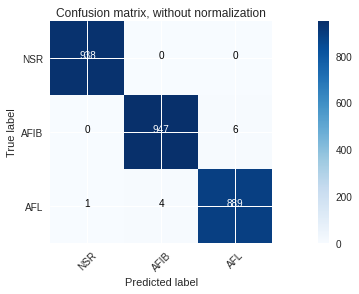

In [28]:
y_pred = tf.argmax(m_resnet_model.predict(X_arhyl_test), axis=-1)
# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(y_arhy_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['NSR', 'AFIB','AFL'],
                      title='Confusion matrix, without normalization')

In [30]:
m_resnet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100, 1)]     0           []                               
                                                                                                  
 conv1d_12 (Conv1D)             (None, 69, 64)       2112        ['input_3[0][0]']                
                                                                                                  
 conv1d_13 (Conv1D)             (None, 69, 64)       131136      ['conv1d_12[0][0]']              
                                                                                                  
 add_10 (Add)                   (None, 69, 64)       0           ['conv1d_12[0][0]',              
                                                                  'conv1d_13[0][0]']        